### 初始化

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
sys.path.append('../')

### 读取环境变量文件和工具config配置

In [3]:
from dotenv import load_dotenv
import os
from modelscope.utils.config import Config

# 读取环境变量，里面需要配置modelscope token来remote调用AI模型
load_dotenv('../config/.env', override=True)

# 读取工具调用CONFIG文件，包括工具的名称和远程请求url
tool_cfg_file = os.getenv('TOOL_CONFIG_FILE') 
print(tool_cfg_file)
tool_cfg = Config.from_file(tool_cfg_file)

2023-09-04 20:08:13,761 - modelscope - INFO - PyTorch version 2.0.1+cu117 Found.
2023-09-04 20:08:13,765 - modelscope - INFO - Loading ast index from /mnt/workspace/.cache/modelscope/ast_indexer
2023-09-04 20:08:13,792 - modelscope - INFO - Loading done! Current index file version is 1.8.4, with md5 19a5f85d75c8eaa96a7eba32b8e082cb and a total number of 902 components indexed


../config/cfg_tool_new.json


### 构建工具调用向量检索

In [4]:
from langchain.embeddings import ModelScopeEmbeddings, DashScopeEmbeddings
from langchain.vectorstores import FAISS
from modelscope_agent.retrieve import ToolRetrieval

# 第一种向量方案，基于阿里云DashScope向量API服务方式
embeddings = DashScopeEmbeddings(model="text-embedding-v1")

# 第二种向量方案，基于魔搭社区开源向量模型
# model_id = 'damo/nlp_corom_sentence-embedding_chinese-base'
# embeddings = ModelScopeEmbeddings(model_id=model_id)

# 基于FAISS构建向量检索引擎
tool_retrieval = ToolRetrieval(embeddings, FAISS) 


### 中枢大模型启动

In [5]:
from modelscope_agent.llm import LLMFactory
from modelscope.hub.api import HubApi

model_name = 'modelscope-agent-qwen-7b'
model_cfg = {
    'modelscope-agent-qwen-7b':{
        'model_id': 'damo/MSAgent-Qwen-7B',
        'model_revision': 'v1.0.1',
        'use_raw_generation_config': True,
        'custom_chat': True
    }
}


llm = LLMFactory.build_llm(model_name, model_cfg)


[2023-09-04 20:08:16,241] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-09-04 20:08:16.636401: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-09-04 20:08:17,871 - modelscope - INFO - Use user-specified model revision: v1.0.1
The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".


### Agent构建

In [6]:
from modelscope_agent.prompt import MSPromptGenerator
from modelscope_agent.agent import AgentExecutor

prompt_generator = MSPromptGenerator(system_template="你是达摩院的ModelScopeGPT（魔搭助手），你是个大语言模型， 是2023年达摩院的工程师训练得到的。\
你有多种能力，可以通过插件集成魔搭社区的模型api来回复用户的问题，还能解答用户使用模型遇到的问题和模型知识相关问答。")

# 构建Agent，需要传入llm，工具配置config以及工具检索
agent = AgentExecutor(llm, tool_cfg, tool_retrieval=tool_retrieval, prompt_generator=prompt_generator)

**************************************************round 1**************************************************

<IPython.core.display.JSON object>

2023-09-04 20:10:00,179 - modelscope - INFO - Use user-specified model revision: v1.0.0
The config attributes {'force_upcast': True} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
Token indices sequence length is longer than the specified maximum sequence length for this model (131 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['��率高, 后印象派风格, 好像是一场花间品酒会 。']
Token indices sequence length is longer than the specified maximum sequence length for this model (131 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['��率高, 后印象派风格, 好像是一场花间品酒会 。']


  0%|          | 0/50 [00:00<?, ?it/s]

**************************************************round 2**************************************************

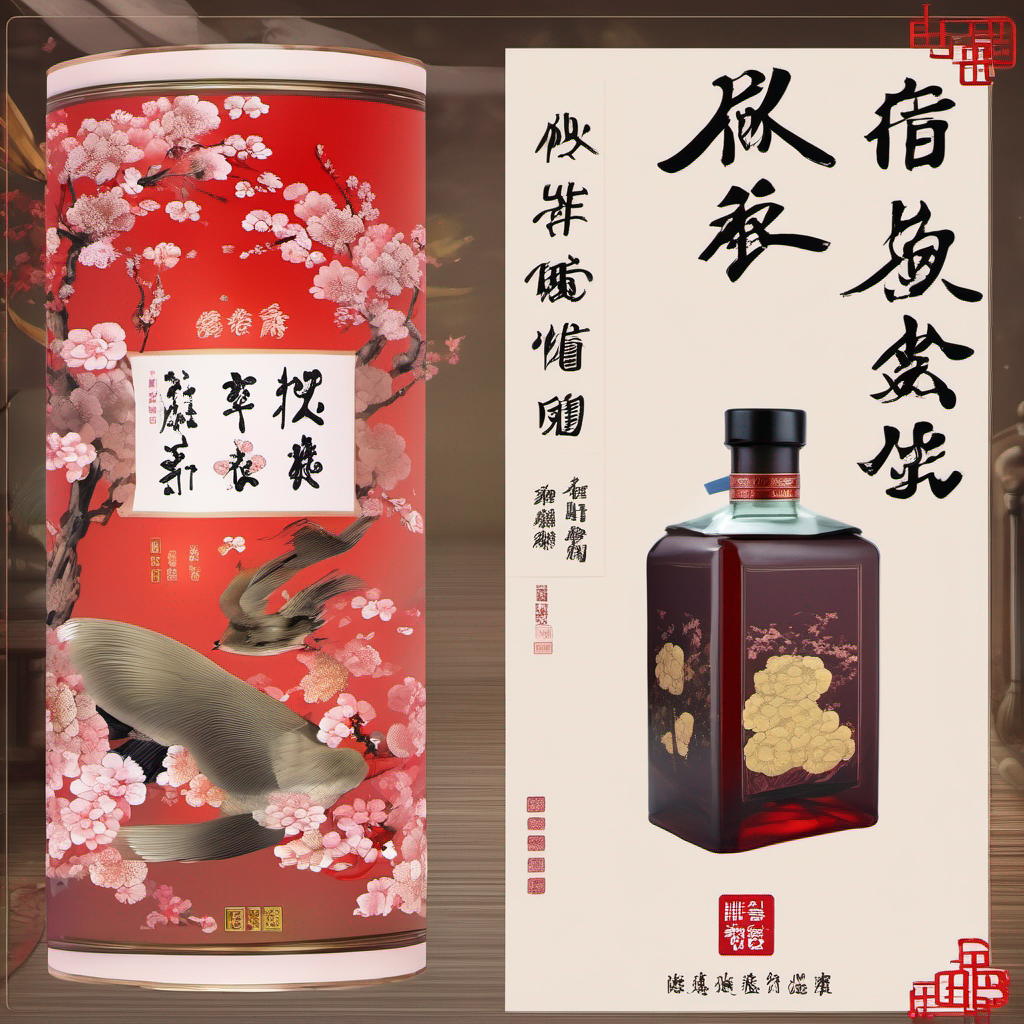

请见以下图片。



[{'result': ![IMAGEGEN](./tmp/tmphs8qszj5/ca4aebf1-b5d0-441e-afb0-0917a5c8ceab.png)}]

In [7]:
# 重置对话，清空对话历史
agent.reset()

# remote=True为调用modelscope api，该服务免费支持QPS较低，建议部署在本地，将remote=False
agent.run("生成一张有花有酒的图片")